# IMPORTING THE LIBRARIES

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import precision_recall_curve, auc
from joblib import dump, load
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
warnings.filterwarnings("ignore", category=UserWarning, module="skopt")
%matplotlib inline

## Financial Dataset for Fraud Detection in a Company

This dataset contains information about financial transactions in a company and is specifically designed for fraud detection. It consists of the following 9 columns:

- **step**: The number of minutes elapsed between each transaction.
- **type**: The type of transaction, which can be one of the following categories: CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER.
- **amount**: The amount of money involved in the transaction.
- **nameOrig**: The name of the person or entity originating the transaction.
- **oldbalanceOrg**: The original balance of the account before the transaction took place.
- **newbalanceOrig**: The balance of the account after the transaction was performed.
- **nameDest**: The name of the person or entity receiving the transaction.
- **oldbalanceDest**: The original balance of the recipient's account before the transaction took place.
- **newbalanceDest**: The balance of the recipient's account after the transaction was performed.

The data in this dataset is used to detect fraud in financial transactions. It can be used to train machine learning models to identify fraudulent transactions and to prevent fraudulent activities in a company.


# LOADING THE DATASET

In [2]:
data = pd.read_csv('/kaggle/input/pythonforml/data.csv')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project/data.csv')

In [3]:
data_temp = pd.read_csv('/kaggle/input/pythonforml/data.csv')
# data_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project/data.csv')

# DATA EXPLORATION

### 1. check target column for data imbalance-- to balance data set before train/test models
### 2. explore and find out which columns to use for modeling

In [4]:
# check total number of rows and columns
print('total rows and columns:', data.shape)

total rows and columns: (6362620, 11)


In [5]:
# take a look at the data
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# check data for duplicates
data = data.drop_duplicates()

# check the number of total rows again, in this case, there are no duplicates
print('total rows and columns after drop duplicates', data.shape)

total rows and columns after drop duplicates (6362620, 11)


In [7]:
# check null values  -- data has no missing values
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
data.info()      # show numerical and character columns
# find out which columns are relevant to use in the models, by looking at the numeric and categorical values separately

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB


In [9]:
# create column list, so all modifications made to the orignal dataframe
num_col_list = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']
char_col_list = ['type','nameOrig','nameDest']

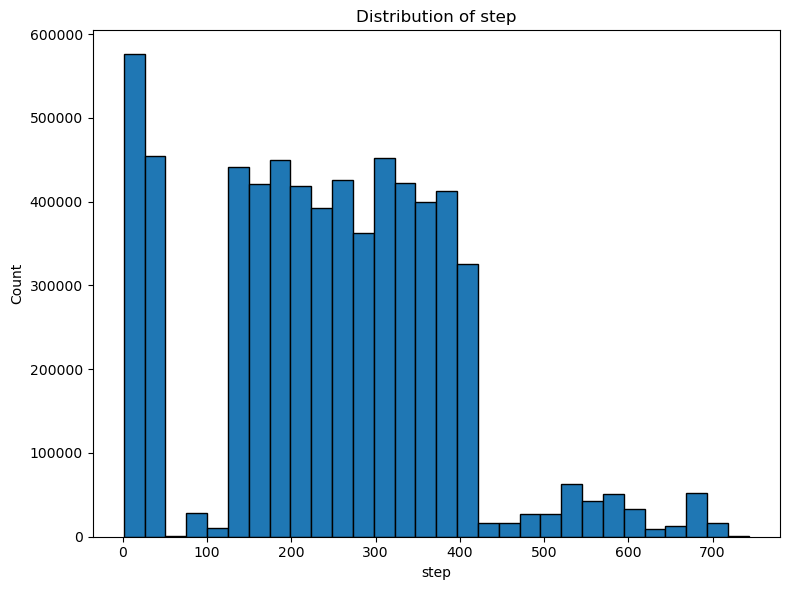

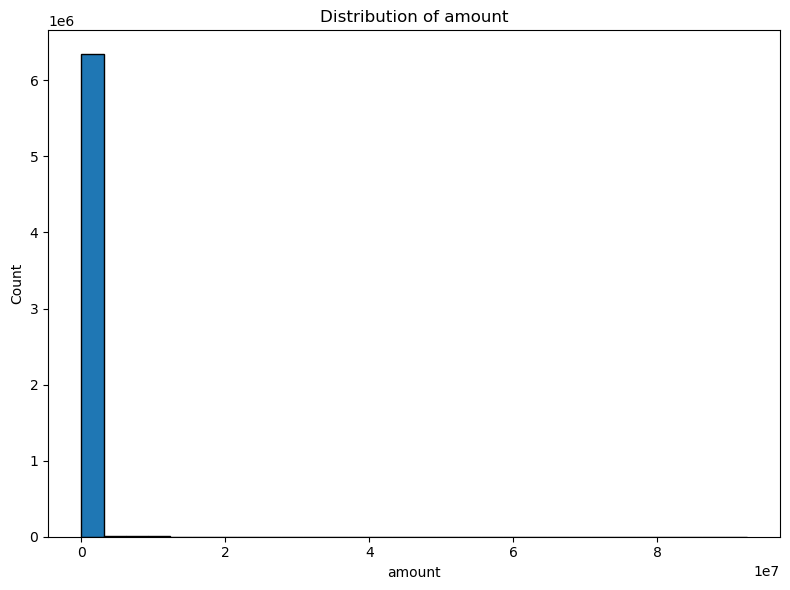

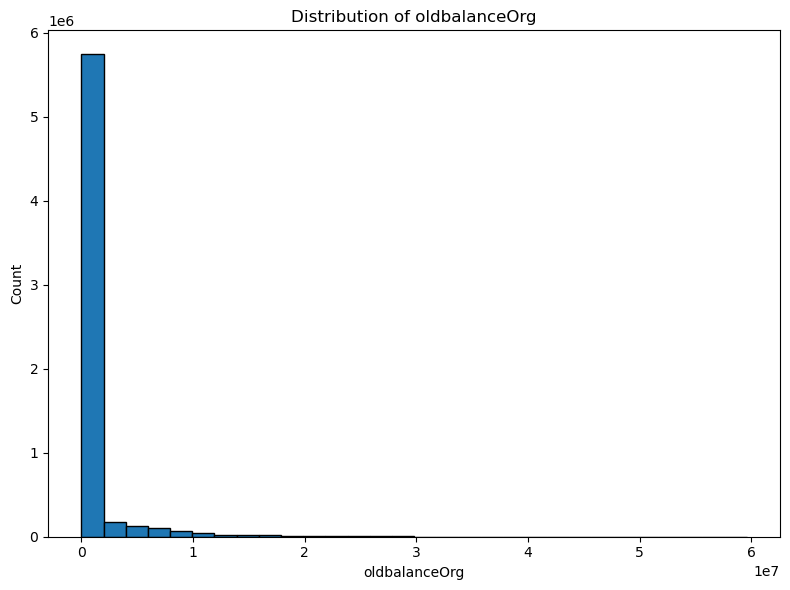

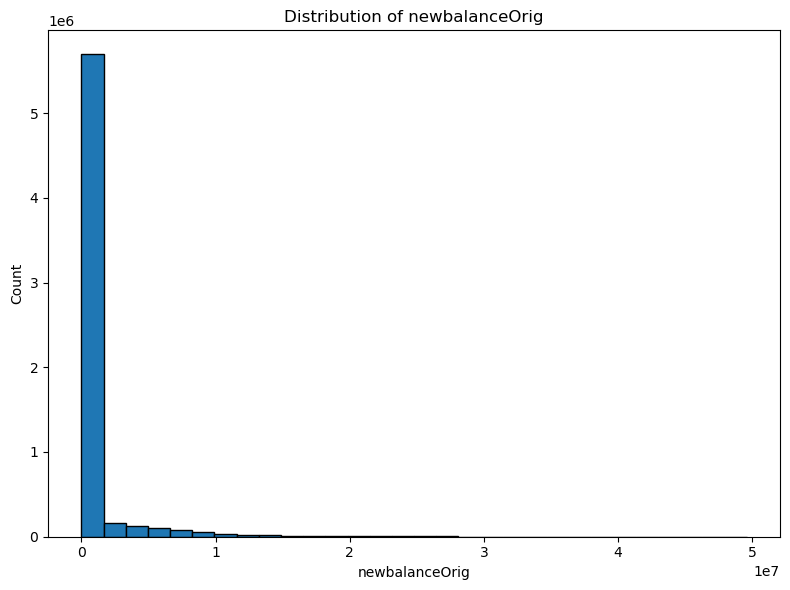

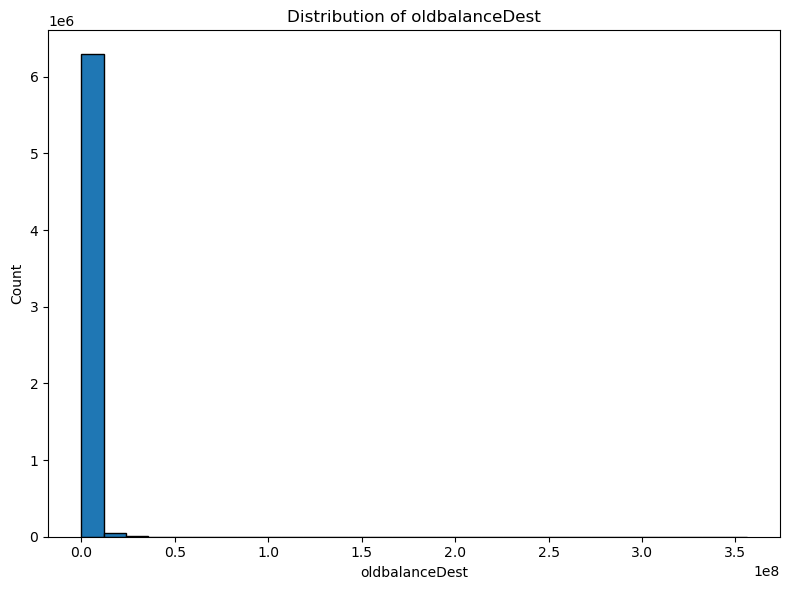

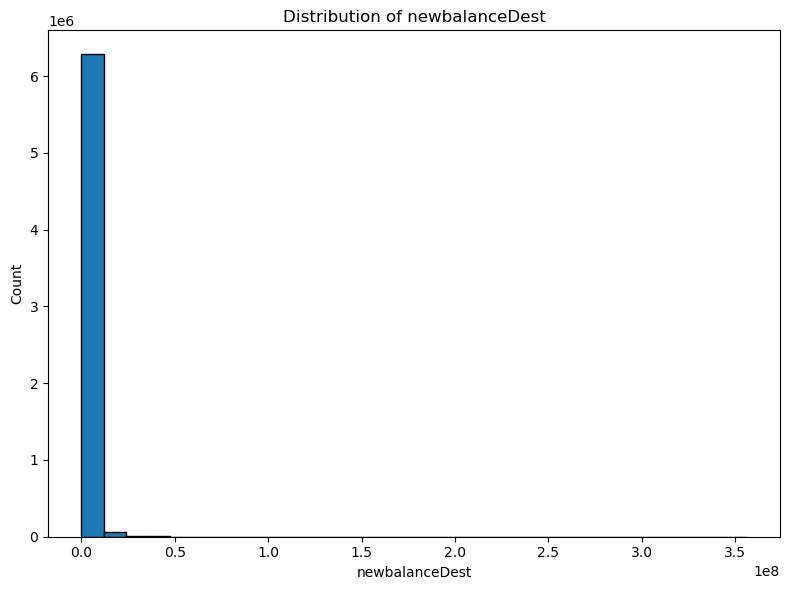

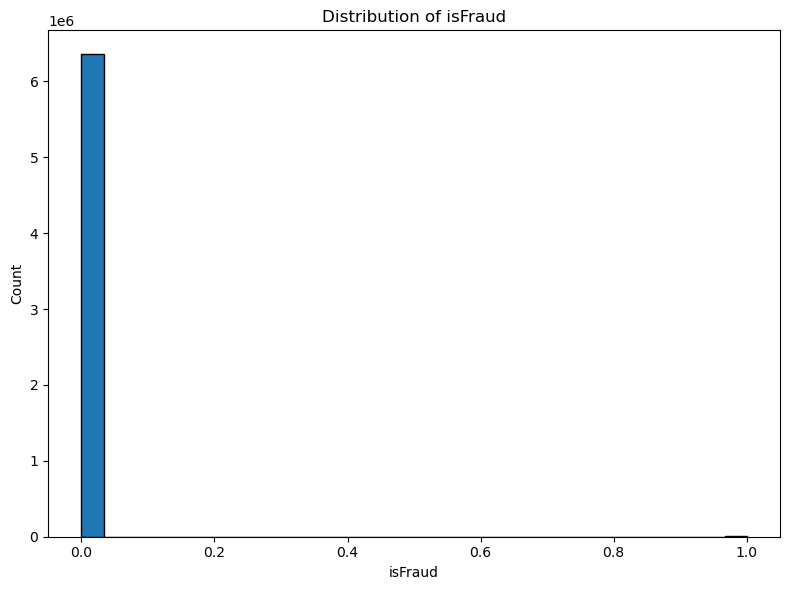

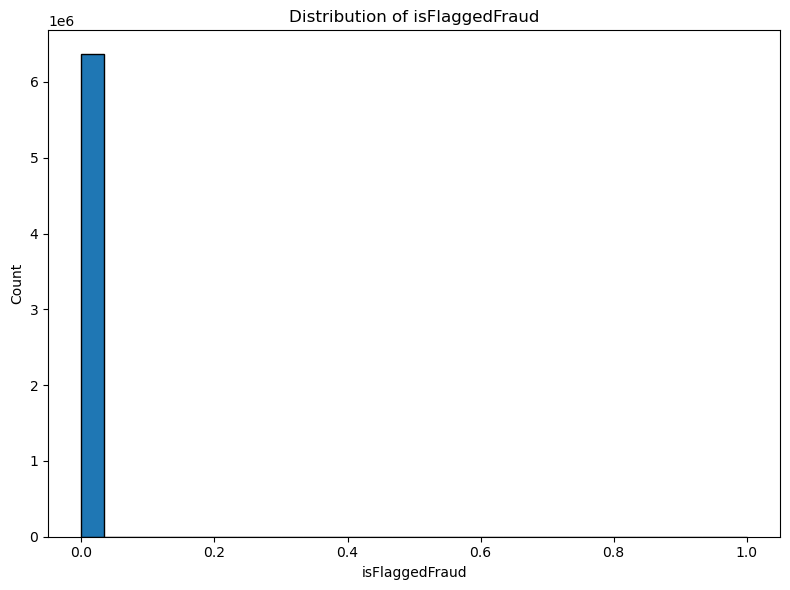

In [10]:
color = '#1f77b4'

# Vẽ biểu đồ histogram cho các biến số
for column in num_col_list:
    plt.figure(figsize=(8, 6))

    # Vẽ biểu đồ histogram
    plt.hist(data[column], bins=30, color=color, edgecolor='black')

    # Thiết lập tiêu đề và nhãn trục
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

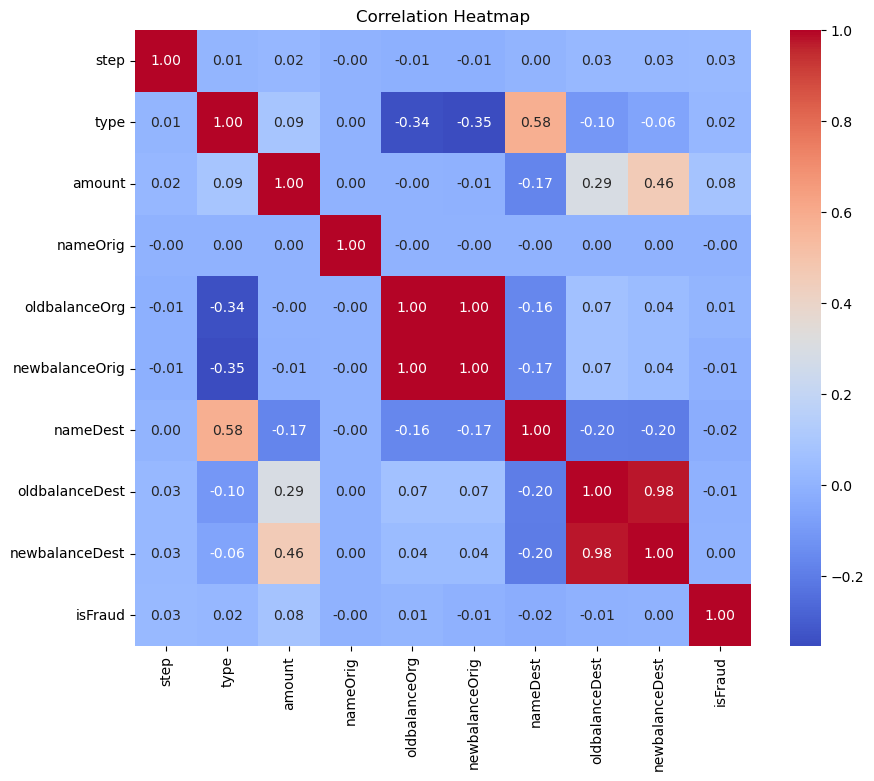

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo DataFrame với các cột value và target
columns = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']
target = 'isFraud'
df = data_temp[columns + [target]]

df_encoded = df.copy()
for col in ['type', 'nameOrig', 'nameDest']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Tính ma trận tương quan
correlation_matrix = df_encoded.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
# too many unique values in nameOrig, nameDest, we do some feature engineering-- assign them into C or M, customer or merchant
data['nameOrig'] = data['nameOrig'].apply(lambda x: x[0:1])
data['nameOrig'].value_counts()
data['nameDest'] = data['nameDest'].apply(lambda x: x[0:1])
data['nameDest'].value_counts()
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C,170136.00,160296.36,M,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C,21249.00,19384.72,M,0.0,0.00,0,0
2,1,TRANSFER,181.00,C,181.00,0.00,C,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C,181.00,0.00,C,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C,41554.00,29885.86,M,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C,53860.00,46042.29,M,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C,183195.00,176087.23,M,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C,176087.23,168225.59,M,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C,2671.00,0.00,M,0.0,0.00,0,0
9,1,DEBIT,5337.77,C,41720.00,36382.23,C,41898.0,40348.79,0,0


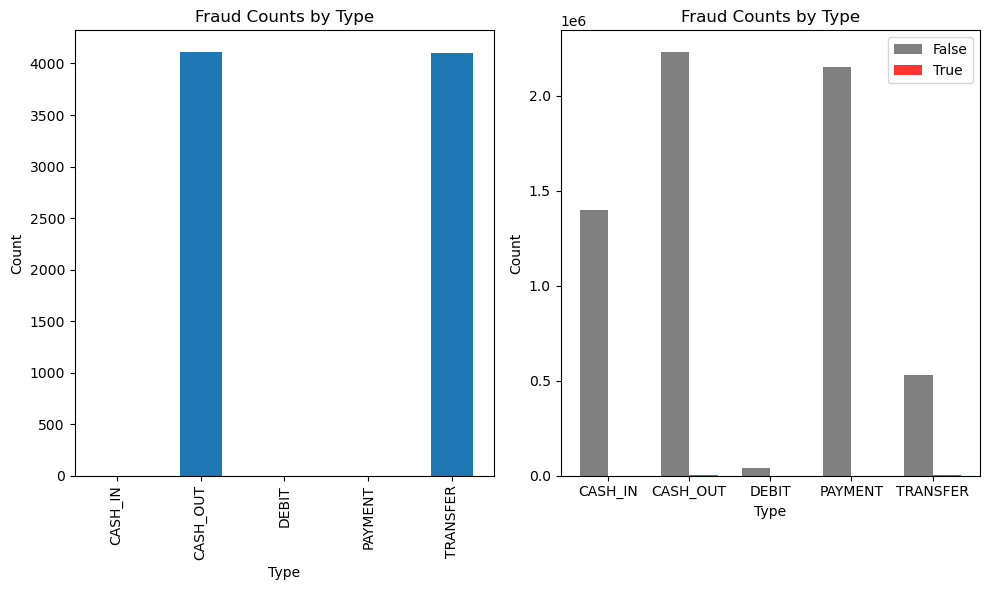

In [13]:
# Tạo pivot table
fraud_type_counts = pd.pivot_table(data, index='isFraud', columns='type', values='nameDest', aggfunc='count')

# Lưu kết quả vào biến
fraud_type_counts_chart_1 = fraud_type_counts.iloc[1]  # Chỉ lấy hàng tương ứng với fraud
fraud_type_counts_chart_1 = fraud_type_counts_chart_1.rename({0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'})

# Vẽ biểu đồ so sánh với fraud
plt.figure(figsize=(10, 6))

# Biểu đồ loại giao dịch 1 (type)
plt.subplot(1, 2, 1)
fraud_type_counts_chart_1.plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Fraud Counts by Type')

# Tạo pivot table
fraud_type_counts = pd.pivot_table(data, index='isFraud', columns='type', values='nameDest', aggfunc='count')

# Lưu kết quả vào biến
fraud_type_counts_chart_2 = fraud_type_counts.iloc[:, 0:5]  # Lấy tất cả cột từ 0 đến 4 (bao gồm cả 'CASH_IN')
fraud_type_counts_chart_2.columns = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

# Thay đổi thứ tự cột trong dataframe
fraud_type_counts_chart_2 = fraud_type_counts_chart_2[['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']]

# Vẽ biểu đồ cột đôi
plt.subplot(1, 2, 2)

# Chỉ số các loại giao dịch
x = np.arange(len(fraud_type_counts_chart_2.columns))

# Chiều rộng của cột
width = 0.35

# Biểu đồ loại giao dịch 2 (type)
plt.bar(x - width/2, fraud_type_counts_chart_2.iloc[0], width, color='gray', label='False')
plt.bar(x + width/2, fraud_type_counts_chart_2.iloc[1], width, color='red', label='True', alpha=0.8)

# Thiết lập các thông số biểu đồ
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Fraud Counts by Type')
plt.xticks(x, fraud_type_counts_chart_2.columns)
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

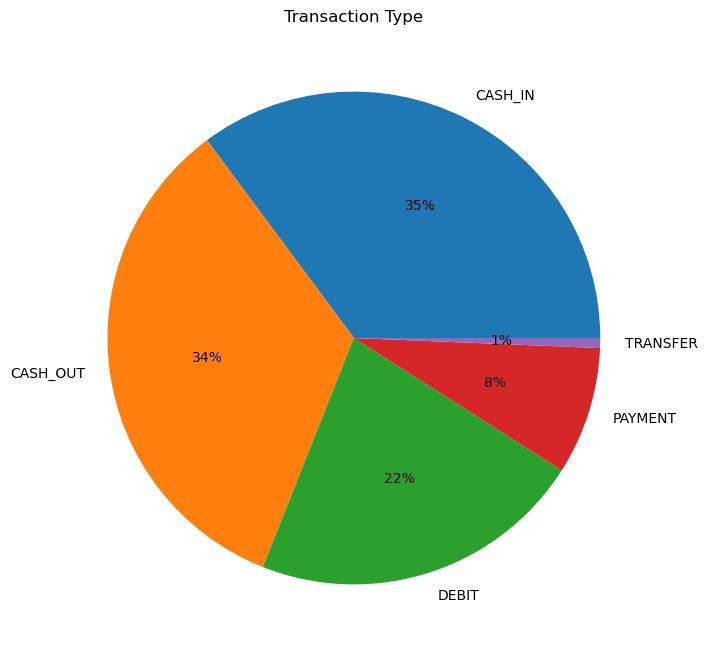

In [14]:
# looks like only case_out and transfer is associate with fraud; and only customer is associate with fraud !

# Danh sách tên loại giao dịch
type_names = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

# Tạo biểu đồ tròn
plt.figure(figsize=(10, 8))
plt.pie(data.type.value_counts().values, labels=type_names, autopct='%.0f%%')

# Thiết lập tiêu đề
plt.title("Transaction Type")

# Hiển thị biểu đồ
plt.show()

In [15]:
data['type'] = data['type']
data_counts = data['type'].value_counts()
print(data_counts)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [16]:
# Số lượng mẫu muốn giữ lại cho "CASH_IN", "PAYMENT" và "DEBIT"
samples_per_type = 10000

# Lọc và giữ nguyên tất cả các mẫu cho "TRANSFER" và "CASH_OUT"
new_data = data[data['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Lọc và giữ lại số lượng mẫu mong muốn cho "CASH_IN", "PAYMENT" và "DEBIT"
for t in ['CASH_IN', 'PAYMENT', 'DEBIT']:
    subset = data[data['type'] == t].sample(n=samples_per_type, random_state=42)
    new_data = pd.concat([new_data, subset])

# Reset chỉ số của dataframe kết quả
new_data = new_data.reset_index(drop=True)
new_data['type'].value_counts()

CASH_OUT    2237500
TRANSFER     532909
CASH_IN       10000
PAYMENT       10000
DEBIT         10000
Name: type, dtype: int64

0    2792196
1       8213
Name: isFraud, dtype: int64


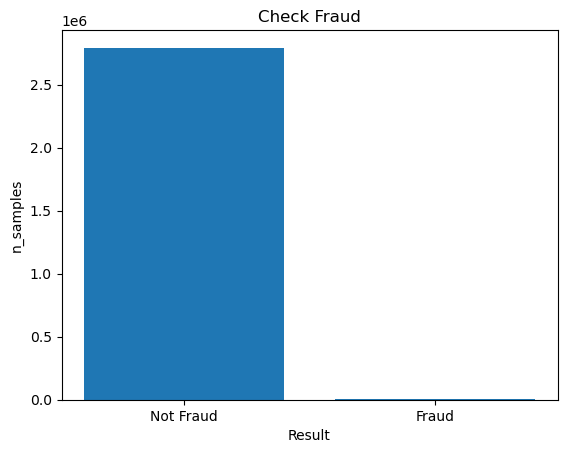

In [17]:
# check target value for imbalance--- in this case the target value is highly imbalanced: fraud: 8213, non-fraud 6354407, that's 1:773 ratio
print(new_data['isFraud'].value_counts())
fraud_counts = new_data['isFraud'].value_counts()
plt.bar(fraud_counts.index, fraud_counts.values)
plt.xlabel('Result')
plt.ylabel('n_samples')
plt.xticks(fraud_counts.index, ['Not Fraud', 'Fraud'])
plt.title('Check Fraud')
plt.show()

# DATA PREPARATION

### 1. Create numeric values for character columns

In [18]:
# create numeric values for character columns
encoder = {}
for i in new_data.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    new_data[i] = encoder[i].fit_transform(new_data[i])
new_data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,4,181.00,0,181.00,0.0,0,0.0,0.00,1,0
1,1,1,181.00,0,181.00,0.0,0,21182.0,0.00,1,0
2,1,1,229133.94,0,15325.00,0.0,0,5083.0,51513.44,0,0
3,1,4,215310.30,0,705.00,0.0,0,22425.0,0.00,0,0
4,1,4,311685.89,0,10835.00,0.0,0,6267.0,2719172.89,0,0
5,1,1,110414.71,0,26845.41,0.0,0,288800.0,2415.16,0,0
6,1,1,56953.90,0,1942.02,0.0,0,70253.0,64106.18,0,0
7,1,1,5346.89,0,0.00,0.0,0,652637.0,6453430.91,0,0
8,1,1,23261.30,0,20411.53,0.0,0,25742.0,0.00,0,0
9,1,4,62610.80,0,79114.00,16503.2,0,517.0,8383.29,0,0


# TRAINING AND TESTING DATA

### Split data into traing set and testing set
### Scale the training data

In [21]:
#Use StandardScaler to normalize the data
normer = StandardScaler()
X_full = new_data.drop(columns=['isFraud'],axis=1)
X_full = X_full.to_numpy()
y_full = new_data['isFraud']
y_full = y_full.astype('int')
y_full = y_full.to_numpy()
# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform StratifiedShuffleSplit cross-validation
for i, (train_index, test_index) in enumerate(sss.split(X_full, y_full), 1):
    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train, y_test = y_full[train_index], y_full[test_index]

X_train = normer.fit_transform(X_train)
X_test = normer.transform(X_test)

# Building model

## Decision Tree

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer

# Define the number of splits and the test size for StratifiedShuffleSplit
num_splits = 3
test_size = 0.3

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size, random_state=42)

# Define the parameter search space
param_space = {
    'max_depth': Integer(1, 10),
}

# Initialize DecisionTreeClassifier with default parameters
tree_model = DecisionTreeClassifier()

# Initialize BayesSearchCV
bayes_search_tree = BayesSearchCV(
    estimator=tree_model,
    search_spaces=param_space,
    n_iter=30,  # Number of iterations for Bayesian Optimization
    cv=sss,
)

# Fit BayesSearchCV on the normalized data
bayes_search_tree.fit(X_train, y_train)

# Get the best parameters and best score
best_params = bayes_search_tree.best_params_
best_score = bayes_search_tree.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Save the model to disk
filename = 'bayes_search_tree.sav'
dump(bayes_search_tree, filename)

Best Parameters: OrderedDict([('max_depth', 10)])
Best Score: 0.9992132669938297


['bayes_search_tree.sav']

Accuracy for class 0: 99.99188213819704%
Accuracy for class 1: 74.7564935064935%
F2 Score: 0.782763895971443


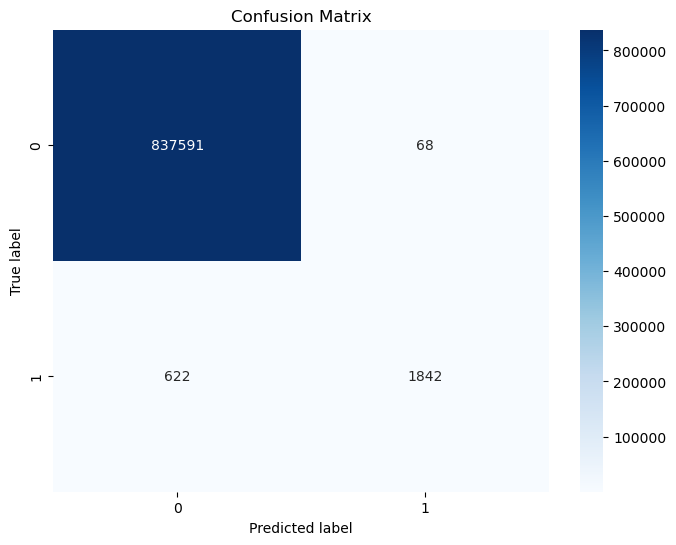

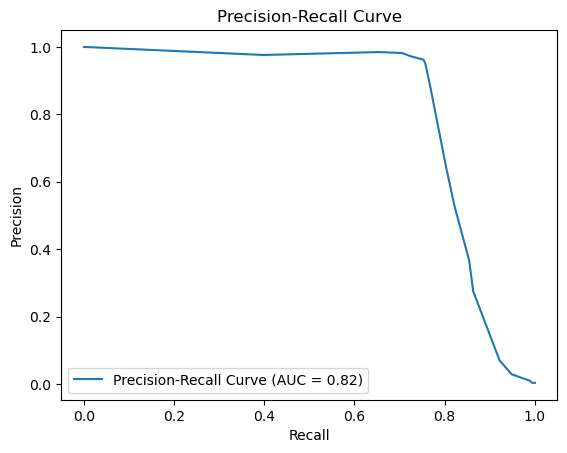

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    837659
           1       0.96      0.75      0.84      2464

    accuracy                           1.00    840123
   macro avg       0.98      0.87      0.92    840123
weighted avg       1.00      1.00      1.00    840123



In [24]:
# specify the path
path = '/kaggle/working/bayes_search_tree.sav'
# load the model
loaded_model_tree = load(path)

# Make predictions on the test data
y_pred = loaded_model_tree.predict(X_test)
y_scores = loaded_model_tree.predict_proba(X_test)[:, 1]

# Accuracy
accuracy_class_0 = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
accuracy_class_1 = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
print(f"Accuracy for class 0: {accuracy_class_0*100}%")
print(f"Accuracy for class 1: {accuracy_class_1*100}%")

# F2 score
f2 = fbeta_score(y_test, y_pred, beta=2)
print(f"F2 Score: {f2}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)  # Calculate precision, recall
pr_auc = auc(recall, precision)  # Calculate Precision-Recall AUC
plt.figure()
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Classification report
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
